In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import time
import torch

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from torchdiffeq import odeint

from data_collector import Omie
from neural_ode import (Decoder, LatentODE, RecurrentNN, RunningAverageMeter, get_batch, 
                        log_normal_pdf, normal_kl, plot_y_y_pred)

# Data Wrangling

df = Omie.download_period_file(filename="marginalpdbc", start_year=2016, end_year=2021)

In [3]:
df = pd.read_csv("day_ahead_market.csv", parse_dates=["date"], 
                  date_parser=lambda x: pd.to_datetime(x, format="%Y-%m-%d"))

df = df[["date", "hour", "spain"]].rename(columns={"spain": "price"})

# remove time change price
df = df[df["hour"] != 25]
# set hour as zero based
df["hour"] = df["hour"] - 1

df["datetime"] = pd.to_datetime(df["date"]) + (df["hour"]).astype('timedelta64[h]')
df.set_index("datetime", inplace=True)
df.sort_index(inplace=True)

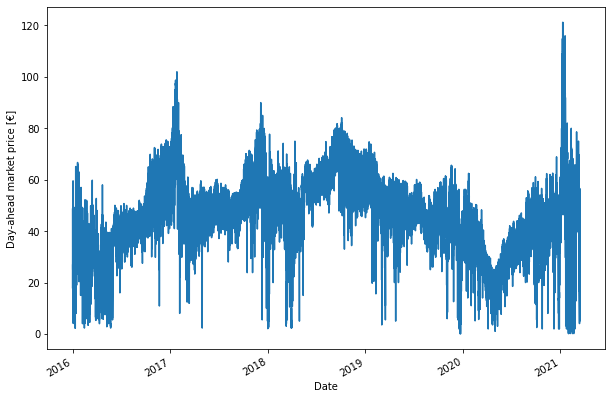

In [4]:
fig, ax = plt.subplots(figsize=(10, 7))
df[["price"]].plot(ax=ax, legend=False)
ax.set_xlabel("Date")
ax.set_ylabel("Day-ahead market price [€]")
plt.show()

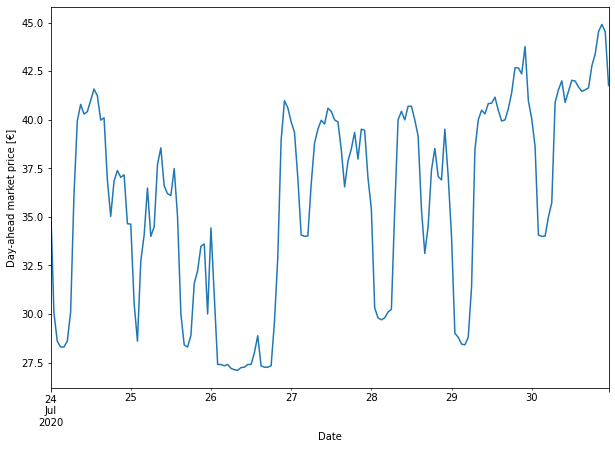

In [5]:
fig, ax = plt.subplots(figsize=(10, 7))
df[["price"]].loc["2020-07-24":"2020-07-30"].plot(ax=ax, legend=False)
ax.set_xlabel("Date")
ax.set_ylabel("Day-ahead market price [€]")
plt.show()

# NeuralODE - LatentODE framework

In [6]:
# split between train and test
split_date = "2021-01-01"
df_train, df_test = df[df["date"] < "2021-01-01"], df[df["date"] >= "2021-01-01"]

# standarise training set
mean_training = df_train["price"].mean()
std_training = df_train["price"].std()
print(f"Mean: {mean_training:.2f}; Std: {std_training:.2f}")

# define training tensor (y_true) -> shape (timesteps, y)
scaled_training = (df_train["price"] - mean_training) / std_training
y_true = torch.from_numpy(np.array(scaled_training, dtype=float)).reshape(-1, 1)
time_tensor = torch.arange(start=0, end=y_true.shape[0], step=1, dtype=torch.float)

Mean: 46.16; Std: 15.10


In [7]:
# configure neural architecture
obs_dim = y_true.shape[-1] # One-dimensional timeseries
latent_dim = 20 # Dimension of the latent space
rnn_hidden = 25 # Dimension of the hidden layer in the recurrentNN encoder 
nbatch = 1 # Number of samples in each minibatch
ode_hidden = 20 # Dimension of the hidden layer in the latent neural ODE
dec_hidden = 20 # Dimenson of the hidden layer in the NN decoder
noise_std = 0.1 # 

lr = 1e-3 # learning rate
epochs = 1_500 # number of epochs
trajectory_time_base = 24 # number of timesteps that enter into the encoder and the neural ODE must integrate
s = 332
#s = 40000

In [8]:
# define architecture
rnn = RecurrentNN(obs_dim=obs_dim, latent_dim=latent_dim, nhidden=rnn_hidden, nbatch=nbatch)
func = LatentODE(latent_dim=latent_dim, nhidden=ode_hidden)
dec = Decoder(latent_dim=latent_dim, obs_dim=obs_dim, nhidden=dec_hidden)

params = (list(rnn.parameters()) + list(func.parameters()) + list(dec.parameters()))

optimizer = torch.optim.Adam(params, lr=lr)
loss_meter = RunningAverageMeter()

Iteration 1: 0500 | total loss -9.696944 | Time: 1.31 mins


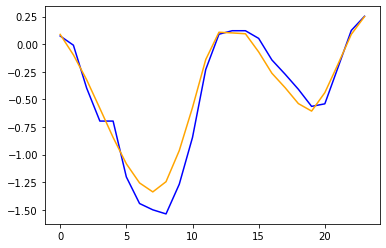

Iteration 1: 1000 | total loss 13.759760 | Time: 1.59 mins


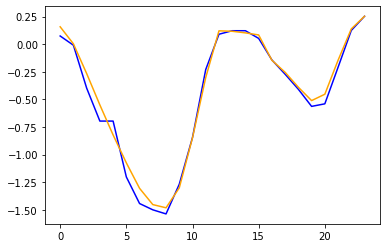

Iteration 1: 1500 | total loss 16.705690 | Time: 1.62 mins


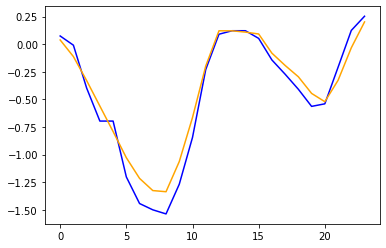

Iteration 2: 0500 | total loss -954.780766 | Time: 1.94 mins


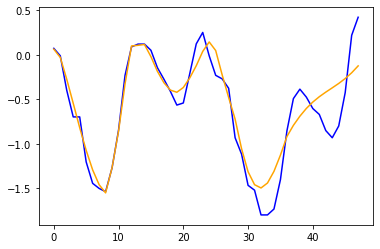

Iteration 2: 1000 | total loss -58.604296 | Time: 2.09 mins


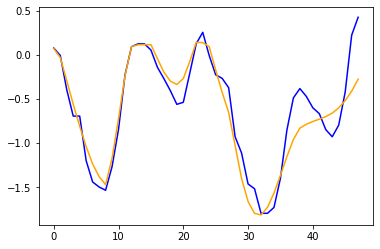

Iteration 2: 1500 | total loss -22.526566 | Time: 2.18 mins


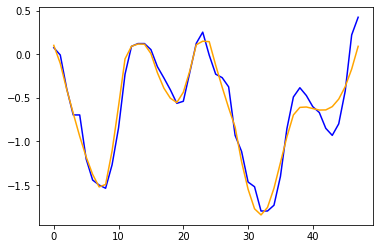

Iteration 3: 0500 | total loss -138.284287 | Time: 3.40 mins


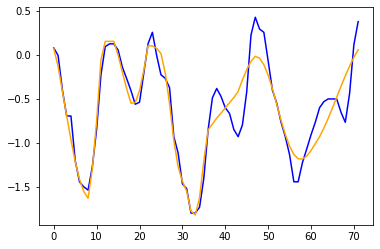

Iteration 3: 1000 | total loss -12.897287 | Time: 4.09 mins


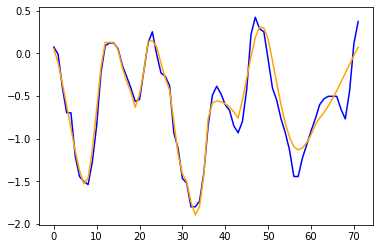

Iteration 3: 1500 | total loss 21.360401 | Time: 4.23 mins


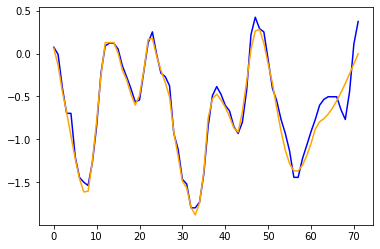

Iteration 4: 0500 | total loss -13.186272 | Time: 6.99 mins


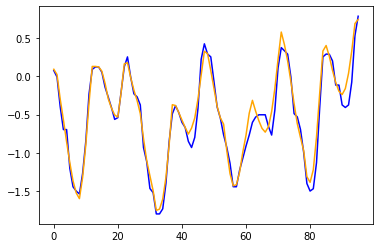

Iteration 4: 1000 | total loss 19.539896 | Time: 9.61 mins


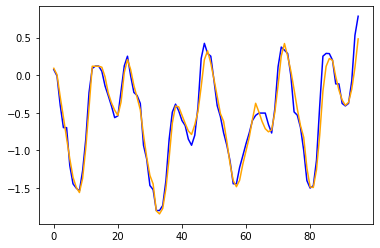

Iteration 4: 1500 | total loss 49.093618 | Time: 10.94 mins


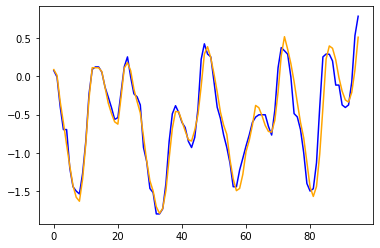

Iteration 5: 0500 | total loss 38.991356 | Time: 14.31 mins


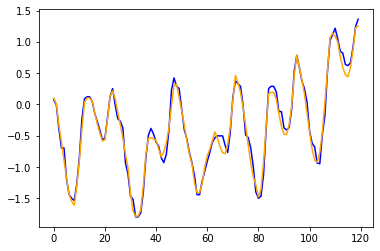

Iteration 5: 1000 | total loss 59.949897 | Time: 10.88 mins


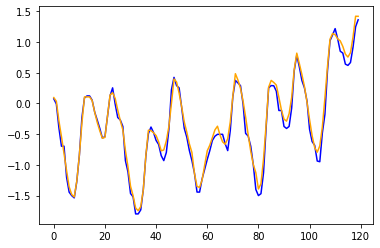

Iteration 5: 1500 | total loss 72.622900 | Time: 10.11 mins


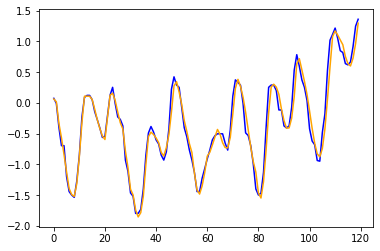

Iteration 6: 0500 | total loss 39.736451 | Time: 12.54 mins


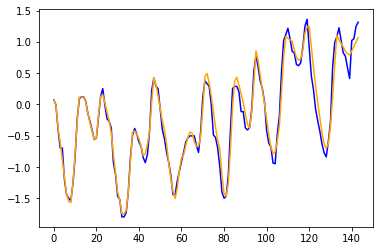

Iteration 6: 1000 | total loss 84.987276 | Time: 14.32 mins


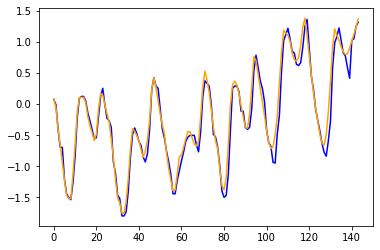

Iteration 6: 1500 | total loss 100.485465 | Time: 13.60 mins


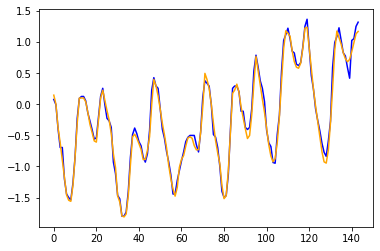

Iteration 7: 0500 | total loss 95.919713 | Time: 16.51 mins


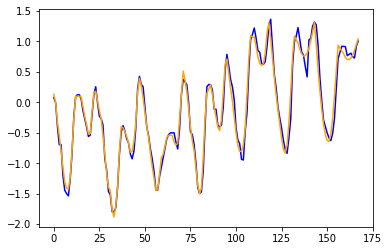

Iteration 7: 1000 | total loss 122.327305 | Time: 16.75 mins


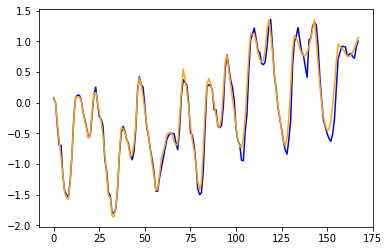

Iteration 7: 1500 | total loss 136.272402 | Time: 17.65 mins


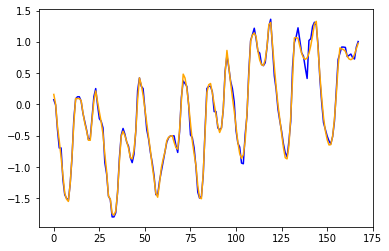

In [9]:
for j in range(1, 8):
    trajectory_time = trajectory_time_base*j
    batch = torch.from_numpy(np.stack([y_true[s: s+trajectory_time]], axis=0)).float()
    samp_ts = time_tensor[:trajectory_time].float()
    
    print("="*30)
    start = time.time()
    loss_meter = RunningAverageMeter()    
    for i in range(1, epochs+1):

        optimizer.zero_grad()

        #batch, samp_ts, s = get_batch(y_true=y_true, t=time_tensor, batch_size=nbatch, trajectory_time=trajectory_time)

        # infer q(z_0) running the RecurrentNN in reversed order
        h = rnn.init_hidden()
        for t in reversed(range(trajectory_time)):
            obs = batch[:, t, :]  # obs shape: (nbatch, obs_dim)
            # feed-forward the rnn with the obs for new t and resulting h from previous t evaluation
            out, h = rnn.forward(x=obs, h=h)

        # last out corresponds to t0, shape: (nbatch, latent_dim * 2)
        # latent space parameters are q mean and log var
        qz0_mean, qz0_logvar = out[:, :latent_dim], out[:, latent_dim:]

        # sample z0 from q distribution using reparametrization trick
        # z = mu + sigma * eps, where eps is drawn from a N(0, I)
        epsilon = torch.randn(qz0_mean.size())
        z0 = qz0_mean + epsilon * torch.exp(0.5 * qz0_logvar)

        # compute ODE in latent space for samp_ts steps and initial value z0
        # shape after permute: (nbatch, nsample, latent_dim)
        pred_z = odeint(func=func, y0=z0, t=samp_ts).permute(1, 0, 2)

        # decode pred_z from latent space to observation space, pred_x shape: (nbatch, nsamples, obs_dim)
        pred_x = dec(pred_z)

        # compute loss function
        # noise_log_var shape: (nbatch, nsample, nobs)
        noise_std_ = torch.zeros(pred_x.size()) + noise_std
        noise_logvar = 2. * torch.log(noise_std_)

        # logpx, shape: (nbatch)
        logpx = log_normal_pdf(x=batch, mean=pred_x, logvar=noise_logvar).sum(-1).sum(-1)

        # p(z0) is assumed to follow N(0, I)
        pz0_mean = torch.zeros(z0.size())
        pz0_logvar = torch.zeros(z0.size())

        analytic_kl = normal_kl(mu1=qz0_mean, logvar1=qz0_logvar, mu2=pz0_mean, logvar2=pz0_logvar).sum(-1)

        # maximising ELBO is similar to minimising Kullack-Leibler(KL) divergence between Q and posterior
        # p(z|x). However, instead of using the posterior, it can be reformulated using Bayes theorem.
        # Assuming that P(z|x) (posterior) = P(x|z) (likelihood) * P(z) (prior) / P(x)
        # ELBO becomes the log-likelihood p(x|z) - KL(Q,P)| max ELBO = min (-1) ELBO
        # Resources:
        # https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73
        # https://en.wikipedia.org/wiki/Evidence_lower_bound
        # TODO: Find how to improve logpx error, since its contribution to the loss is higher
        # kl is close to zero, meaning that qz0 is close to N(0, I)
        loss = torch.mean(-logpx + analytic_kl, dim=0)

        loss.backward()
        optimizer.step()
        loss_meter.update(loss.item())

        if i % 500 == 0:
            end = time.time()
            training_time = (end-start) / 60
            log = f"Iteration {j}: {i:04d} | total loss {-loss_meter.avg:.6f} | Time: {training_time:.2f} mins"
            print(log)
            plot_y_y_pred(y_true=batch, y_pred=pred_x, t=samp_ts)
            start = time.time()
            #plt.show()
            #fig.suptitle(log)
            #plt.pause(3)
    

In [69]:
# test learnt dyanmic
trajectory_time = trajectory_time_base*j
trajectory_time_test = trajectory_time + int(trajectory_time_base)*1
batch = torch.from_numpy(np.stack([y_true[s: s+trajectory_time]], axis=0)).float()
batch_test = torch.from_numpy(np.stack([y_true[s: s+trajectory_time_test]], axis=0)).float()
samp_ts = time_tensor[:trajectory_time].float()
samp_ts_test = time_tensor[:trajectory_time_test].float()

In [70]:
with torch.no_grad():
    
    h = rnn.init_hidden()
    for t in reversed(range(samp_ts.shape[0])):
        obs = batch[:, t, :]
        out, h = rnn.forward(x=obs, h=h)
        
    qz0_mean, qz0_logvar = out[:, :latent_dim], out[:, latent_dim:]
    epsilon = torch.randn(qz0_mean.size())
    z0 = qz0_mean + epsilon * torch.exp(0.5 * qz0_logvar)
    
    pred_z = odeint(func=func, y0=z0, t=samp_ts_test).permute(1, 0, 2)
    
    y_pred = dec(pred_z)

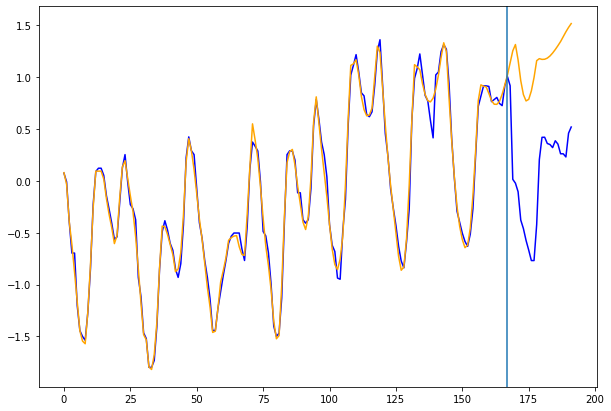

In [71]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(samp_ts_test, batch_test.reshape(-1), color="blue")
ax.plot(samp_ts_test, y_pred.reshape(-1), color="orange")
ax.axvline(x=samp_ts.max().item())
plt.show()